In [1]:
import sys
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time

In [2]:
# provide the path to your local installation of the CROPseq-multi package
CSM_dir = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/csm')

import guide_selection, barcode_selection, oligo_design

# overview

1) **prepare list of gene pairs and combination scheme**

2) **select sgRNA spacer pairs** 

3) **select iBAR pairs** 

4) **randomly assign any unassigned tRNAs**

5) **generate oligos**

# 1. prepare list of gene pairs and combination scheme

### Specifiy precisely how to pair guides in a Genetic Interaction (GI) set (gene pair)

A few example CSV files are provided to specify how guides should be paired. In this example, we will design six constructs per gene pair (for genes A and B). This is a minimal size that has performed well in our screens. We do not recommend smaller sets.

  - the following are unique guides: A1, A2, B1, B2, ctrl1, ctrl2
  - this corresponds to the following constructs:
    - three constructs composed of guides A1, B1, and ctrl1, with a shared tRNA1
        - A1-tRNA1-ctrl1
        - ctrl1-tRNA1-B1
        - A1-tRNA1-B1
    - three constructs composed of guides A2, B2, and ctrl2, with a shared tRNA2
        - ctrl2-tRNA2-A2
        - B2-tRNA2-ctrl2
        - B2-tRNA2-A2

Additional notes:
- for genes that appear in more than one gene pair, this workflow will result in the design of additional single-gene targeting constructs
- these will be retained by default(to match the exact spacer selection, position, control pairing, tRNA selection) but users may wish to filter out any redundant representation of single-gene targeting constructs

In [3]:
GI_set_design = pd.read_csv('input_files/GI_set_design-6.csv')
GI_set_design

,target_pos1,spacer_version_pos1,target_pos2,spacer_version_pos2,tRNA_version
0,A,1,ctrl,1,1
1,ctrl,1,B,1,1
2,A,1,B,1,1
3,ctrl,2,A,2,2
4,B,2,ctrl,2,2
5,B,2,A,2,2


### input the gene pairs to be perturbed

In [4]:
# read in a file where all gene pairs have been specified as follows:
gene_pairs_df = pd.read_csv('input_files/example_gene_pairs.csv')
gene_pairs_df

,target_A,target_B
0,CCT6B,CCT6A
1,HNRNPR,SYNCRIP
2,MAPK3,MAPK1
3,FSTL5,FSTL4
4,PAFAH1B2,PAFAH1B3
5,F11,KLKB1
6,TAF1L,TERF2
7,TRAPPC6B,TRAPPC6A
8,RFX3,RFX2
9,ZNF280B,ZNF280A


In [5]:
# save a text file with all the unique single genes
# use this file to generate candidate sgRNA spacers with CRISPick

pd.Series(list(set(
    gene_pairs_df['target_A'].to_list() + 
    gene_pairs_df['target_B'].to_list()
))).to_csv('input_files/example_gene_pairs_single_genes.txt', sep='\t', index=False)

#### Use CRISPick to select gene-targeting guides

Proceed to CRISPick (https://portals.broadinstitute.org/gppx/crispick/public) to select spacers. While the vast majority of spacers are compatible with our vector design, you may wish to design one or two additional sgRNAs per gene than you anticipate using. For example, if you will use 4 unique sgRNAs per gene, design 5-6 per gene with CRISPick. The highest highest ranked guides will be prioritized.

Save the guide picking results and read them in in the cell below.


In [6]:
# now read in the guides selected with CRISPick
gene_targeting_guides_df = pd.read_table('input_files/CRISPick_output_GI_example.txt')

#### finally, read in a set of control guides

Control guides will be paired with gene-targeting guides for constructs targeting only one gene target.
- For CRISPR-KO, this could be intergenic targeting guides or olfactory receptor targeting guides.
- For CRISPRi, this could be intergenic targeting guides, olfactory receptor targeting guides, or nontargeting guides

Here, we will read in a set of intergenic targeting guides to serve as controls.

In [7]:
# intergenic controls
intergenic_guides_df = pd.read_table('input_files/CRISPick_intergenic_guides.txt')
intergenic_guides_df['Target Gene ID'] = 'INTERGENIC_CONTROL'
intergenic_guides_df['Target Gene Symbol'] = 'INTERGENIC_CONTROL'
intergenic_guides_df

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Alias,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,PAM Policy,Initial Spacing Requirement,Off-Target Match Ruleset Version,Off-Target Tier Policy,Off-Target Match Bin Policy,Strand of sgRNA,Orientation,sgRNA Cut Position (1-based),sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,Exon Number,Target Cut Length,Target Total Length,Target Cut %,Other Target Matches,# Off-Target Tier I Match Bin I Matches,# Off-Target Tier II Match Bin I Matches,# Off-Target Tier III Match Bin I Matches,# Off-Target Tier IV Match Bin I Matches,# Off-Target Tier I Match Bin II Matches,# Off-Target Tier II Match Bin II Matches,# Off-Target Tier III Match Bin II Matches,# Off-Target Tier IV Match Bin II Matches,# Off-Target Tier I Match Bin III Matches,# Off-Target Tier II Match Bin III Matches,# Off-Target Tier III Match Bin III Matches,# Off-Target Tier IV Match Bin III Matches,# Off-Target Tier I Match Bin IV Matches,# Off-Target Tier II Match Bin IV Matches,# Off-Target Tier III Match Bin IV Matches,# Off-Target Tier IV Match Bin IV Matches,On-Target Ruleset,On-Target Efficacy Score,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes
0,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,AGAGTTACGTCGCTTCGATC,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,0,1,0,0,1,0,3,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,ACAATTACTCGGATACGCTC,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,1,1,4,0,12,9,9,1,8,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,GCTGCAGACTAGCTATCGTA,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,1,3,5,1,17,4,8,0,13,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
3,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,TCAGCTCCAAACGTACGTAC,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,1,6,2,0,8,6,4,0,7,2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,ACAGAGTCGCCGCATCGCAC,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,2,4,1,1,17,6,9,3,21,9,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,AGTGCGGATACGCTAAACCA,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,8,6,4,0,26,11,18,0,9,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
196,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,ATAGTCCATTAAGTGCGAAT,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,7,9,7,1,28,6,18,1,27,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
197,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,GGTACACCGTCAGTGATATC,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,8,6,9,2,39,42,95,3,42,24,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
198,(NEG_CONTROL),NaN,9606,INTERGENIC_CONTROL,INTERGENIC_CONTROL,NaN,NaN,CRISPRko,CDS,NaN,NaN,NaN,NaN,1,1,5.20.100,NaN,NaN,NaN,TATGTGACAACCCTACCGAT,NaN,NaN,NaN,NaN,NaN,NaN,ONE_INTERGENIC_SITE,0,0,0,1,0,8,7,4,0,18,11,9,0,13,4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


# 2. pair sgRNAs for genetic interactions

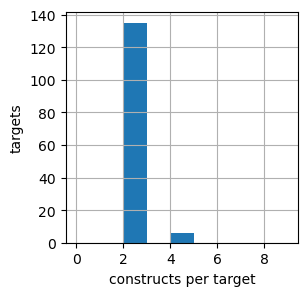

In [8]:
gene_targeting_pairs = guide_selection.pair_guides_for_GI_CRISPick(
    gene_pairs_df, # list of gene pairs
    GI_set_design, # what guide pairs to design (A-ctrl, ctrl-B, A-B)
    gene_targeting_guides_df, # CRISPick design file with all genes for 
    intergenic_guides_df, # source for control spacers
)
gene_targeting_pairs['category']='GENE_TARGETING'

plt.figure(figsize=(3,3))
gene_targeting_pairs.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

### now let's add some controls

Here, we'll add 25 constructs pairing nontargeting guides and 25 constructs pairing intergenic targeting guides.

In [9]:
control_pairs_df = guide_selection.pair_guides_single_target_controls(
    n_intergenic_constructs = 25, # number of intergenic control constructs
    n_nontargeting_constructs = 25, # number of nontargeting control constructs
)

### combine gene-targeting and control pairs

In [10]:
guide_pairs_df = pd.concat([ gene_targeting_pairs, control_pairs_df],
                           ignore_index=True).reset_index(drop=True)
    
guide_pairs_df

,target_pos1,spacer_version_pos1,target_pos2,spacer_version_pos2,tRNA_version,GI_version,tRNA,target,GI_pair,spacer_1,spacer_1_target,spacer_2,spacer_2_target,GI_version_index,target_version,category,target_symbol,spacer_1_pick_order,spacer_2_pick_order
0,A,1.0,ctrl,1.0,1.0,A,tRNA_P,CCT6B,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,GAGATAGTGATACTATCGTC,ctrl,1.0,1,GENE_TARGETING,NaN,NaN,NaN
1,ctrl,1.0,B,1.0,1.0,B,tRNA_P,CCT6A,CCT6B_CCT6A,GAGATAGTGATACTATCGTC,ctrl,AAGGGCACCATGAAGATGTA,CCT6A,2.0,1,GENE_TARGETING,NaN,NaN,NaN
2,A,1.0,B,1.0,1.0,AB,tRNA_P,CCT6B_CCT6A,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,AAGGGCACCATGAAGATGTA,CCT6A,3.0,1,GENE_TARGETING,NaN,NaN,NaN
3,ctrl,2.0,A,2.0,2.0,A,tRNA_Q,CCT6B,CCT6B_CCT6A,AGGTCGATCACGCCATAACT,ctrl,ATGTTCTAGCTACATCTAAG,CCT6B,4.0,2,GENE_TARGETING,NaN,NaN,NaN
4,B,2.0,ctrl,2.0,2.0,B,tRNA_Q,CCT6A,CCT6B_CCT6A,CAGAGCTAAAAGGAGAAATA,CCT6A,AGGTCGATCACGCCATAACT,ctrl,5.0,2,GENE_TARGETING,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTERGENIC_CONTROL,NaN,ACAGCAGCTACTGTATCGAT,NaN,GTGACACCGCAATTCAACCA,NaN,NaN,21,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTERGENIC_CONTROL,NaN,ACAGCGTTGCTCGTATACAG,NaN,TGAACACGAGACCTACACTC,NaN,NaN,22,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1
341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTERGENIC_CONTROL,NaN,TCTGTTACCGAGCCTAATGC,NaN,GTTGAGCTGATCCTACGTAT,NaN,NaN,23,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1
342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTERGENIC_CONTROL,NaN,TAAGTGCCTACGAAGTTATC,NaN,ACTGGTACGTACCCTCTATA,NaN,NaN,24,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1


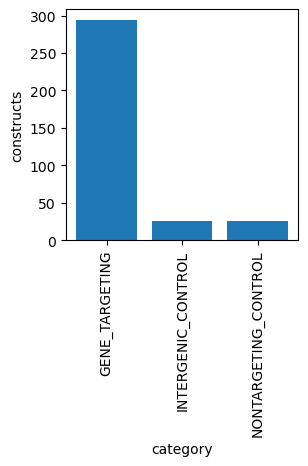

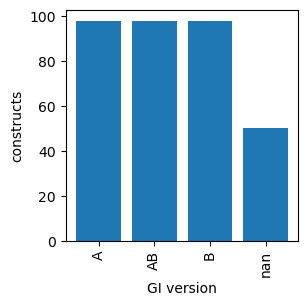

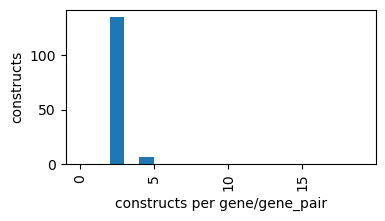

In [11]:
plt.figure(figsize=(3,3))
plt.bar(guide_pairs_df.value_counts('category').index,
        guide_pairs_df.value_counts('category').values)
plt.xlabel('category')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.bar(guide_pairs_df.value_counts('GI_version', dropna=False).index.astype('str'),
        guide_pairs_df.value_counts('GI_version', dropna=False).values)
plt.xlabel('GI version')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(4,2))
plt.hist(guide_pairs_df.value_counts('target', dropna=False), bins=np.arange(0,20,1))
plt.xlabel('constructs per gene/gene_pair')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

# 3. iBAR selection

## A brief overview of methods for iBAR pairing

There are diverse ways to encode information in iBARs, with some methods offering distinct advantages. We have implemented a few methods, described below.

For optical pooled screening applications, consider if you will employ multiplexed decoding (mRNA detection) or serial decoding (T7 IVT detection).

### 1) 'positional'
- all iBARs are unique (iBARs are *not* repeated in either position) and iBAR position is encoded in the first base identity
    - iBAR1 starts with 'A' or 'G' (5'-3' mRNA orientation)
    - iBAR2 starts with 'C' or 'T' (5'-3' mRNA orientation)
- there is a guaranteed edit distance between all iBARs in a library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct
    - for serial decoding (T7 IVT), modestly less efficient decoding vs 'random_shared', 'random_unique', or 'matched'

### 2) 'random_unique'
- all iBARs are unique (iBARs are *not* repeated in either position) 
- there is a guaranteed edit distance between all iBARs in the library
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, even if the position (iBAR1 or iBAR2) is unknown

### 3) 'random_shared'
- iBARs are unique to a position (i.e. iBAR1 or iBAR2) but shared between positions (iBARs *may be* repeated between positions 1 and 2)
    - iBAR pairs are unique, independent of position (we do not allow BC1-BC2 and BC2-BC1 to co-occur)
- there is a guaranteed edit distance between all iBARs in a position (iBAR1 or iBAR2)
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - multiplexed decoding (mRNA) enables recombination detection and more efficient decoding
        - observation of either barcode alone is sufficient to identify a construct, *only if* the position (iBAR1 or iBAR2) is known

### 4) 'matched'
- both iBARs of a construct are the same barcode (i.e. iBAR1 = iBAR2)
- across constructs, there is a guaranteed edit distance between iBARs
- yield approximately twice as many barcode pairs as 'random_unique' for a given barcode length and edit distance
- compatible with repurposing iBAR2 as a unique molecular identifier
- for optical pooled screens:
    - no advantage in decoding efficiency for multiplexed decoding (mRNA) compared to serial decoding (T7 IVT)

### pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)
- barcodes are not necessarily compatible across these sets
- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [12]:
# import all the barcode sets
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n6_k3_Levenshtein.noBsmBI.csv,6.0,3.0,Levenshtein,87.0
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n6_k2_Levenshtein.noBsmBI.csv,6.0,2.0,Levenshtein,883.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0


In [13]:
library_design_df = barcode_selection.automated_iBAR_assignment(guide_pairs_df, distance=3, method='positional')


Edit distance 3 in 8 cycles

generating and filtering complete iBARs...


100%|███████████████████████████████████████| 835/835 [00:00<00:00, 5417.23it/s]



optimizing barcode pairing...
attempt 1/3


100%|█████████████████████████████████████| 896/896 [00:00<00:00, 394385.18it/s]



designed 369 barcode pairs

determining cycling requirements for decoding...

barcode 1 is unique in set(barcode 1) in:
 6 cycles

barcode 2 is unique in set(barcode 2) in:
 6 cycles

barcodes in set(barcode 1, barcode 2) are unique in:
 6 cycles

simulating recombination detection...



barcode pair is unique in set(1-2, 2-1) in :
 3 cycles with 52% recombination detection
 or:
 4 cycles with 97% recombination detection

simulating recombination detection...



barcode pair is unique in set(1-2) in:
 3 cycles with 52% recombination detection
 or:
 4 cycles with 96% recombination detection


# 4. randomly assign any unassigned tRNAs

in this case, only negative controls have note been assigned tRNAs

In [14]:
library_design_df = oligo_design.assign_tRNAs(library_design_df)
library_design_df

,target_pos1,spacer_version_pos1,target_pos2,spacer_version_pos2,tRNA_version,GI_version,tRNA,target,GI_pair,spacer_1,spacer_1_target,spacer_2,spacer_2_target,GI_version_index,target_version,category,target_symbol,spacer_1_pick_order,spacer_2_pick_order,iBAR_1,iBAR_2
0,A,1.0,ctrl,1.0,1.0,A,tRNA_P,CCT6B,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,GAGATAGTGATACTATCGTC,ctrl,1.0,1,GENE_TARGETING,NaN,NaN,NaN,GGTTCAAGACCC,CTAAGTCTATAC
1,ctrl,1.0,B,1.0,1.0,B,tRNA_P,CCT6A,CCT6B_CCT6A,GAGATAGTGATACTATCGTC,ctrl,AAGGGCACCATGAAGATGTA,CCT6A,2.0,1,GENE_TARGETING,NaN,NaN,NaN,ACGGTATAAATG,TACCTCTGACCA
2,A,1.0,B,1.0,1.0,AB,tRNA_P,CCT6B_CCT6A,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,AAGGGCACCATGAAGATGTA,CCT6A,3.0,1,GENE_TARGETING,NaN,NaN,NaN,ACGAAGCTCCTC,CCATGCTTAGGG
3,ctrl,2.0,A,2.0,2.0,A,tRNA_Q,CCT6B,CCT6B_CCT6A,AGGTCGATCACGCCATAACT,ctrl,ATGTTCTAGCTACATCTAAG,CCT6B,4.0,2,GENE_TARGETING,NaN,NaN,NaN,ACCGATGTGCAC,CGTCCATGGAAA
4,B,2.0,ctrl,2.0,2.0,B,tRNA_Q,CCT6A,CCT6B_CCT6A,CAGAGCTAAAAGGAGAAATA,CCT6A,AGGTCGATCACGCCATAACT,ctrl,5.0,2,GENE_TARGETING,NaN,NaN,NaN,GGCAGTAGTAAA,CAGGGACAGAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,ACAGCAGCTACTGTATCGAT,NaN,GTGACACCGCAATTCAACCA,NaN,NaN,21,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,ACTCCCTGGGCT,CAACCTCTACAA
340,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,ACAGCGTTGCTCGTATACAG,NaN,TGAACACGAGACCTACACTC,NaN,NaN,22,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,AAATGGAGGCGT,CAGTCCTACGAT
341,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,TCTGTTACCGAGCCTAATGC,NaN,GTTGAGCTGATCCTACGTAT,NaN,NaN,23,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,AACTGCCCGAAT,CTGACTAACTAG
342,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_Q,INTERGENIC_CONTROL,NaN,TAAGTGCCTACGAAGTTATC,NaN,ACTGGTACGTACCCTCTATA,NaN,NaN,24,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,ACAGCTAATCAA,TCAATGAGCTAT


# 5. generate oligos

- successful oligo designs will populate the 'oligo' column in oligo_design_df
- if any oligos were not successfully built, those rows will be returned in 'df_failed' for inspesction
  - if all oligos were successfully built, 'df_failed' will be an empty dataframe
- tRNAs may be substituted at this step to remove incompatible sequences.

In [15]:
# inspect any designs for which oligos could not be built
# (empty dataframe if there were no failures)
oligo_design_df, df_failed = oligo_design.generate_oligos(library_design_df)

In [16]:
df_failed

""


In [17]:
# successful designs
oligo_design_df

,target_pos1,spacer_version_pos1,target_pos2,spacer_version_pos2,tRNA_version,GI_version,tRNA,target,GI_pair,spacer_1,spacer_1_target,spacer_2,spacer_2_target,GI_version_index,target_version,category,target_symbol,spacer_1_pick_order,spacer_2_pick_order,iBAR_1,iBAR_2,dialout,dialout_fwd,dialout_rev,tRNA_leader,oligo,oligo_len
0,A,1.0,ctrl,1.0,1.0,A,tRNA_P,CCT6B,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,GAGATAGTGATACTATCGTC,ctrl,1.0,1,GENE_TARGETING,NaN,NaN,NaN,GGTTCAAGACCC,CTAAGTCTATAC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAATGGAGATGAAGCATAAATT...,300
1,ctrl,1.0,B,1.0,1.0,B,tRNA_P,CCT6A,CCT6B_CCT6A,GAGATAGTGATACTATCGTC,ctrl,AAGGGCACCATGAAGATGTA,CCT6A,2.0,1,GENE_TARGETING,NaN,NaN,NaN,ACGGTATAAATG,TACCTCTGACCA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAGAGATAGTGATACTATCGTC...,300
2,A,1.0,B,1.0,1.0,AB,tRNA_P,CCT6B_CCT6A,CCT6B_CCT6A,ATGGAGATGAAGCATAAATT,CCT6B,AAGGGCACCATGAAGATGTA,CCT6A,3.0,1,GENE_TARGETING,NaN,NaN,NaN,ACGAAGCTCCTC,CCATGCTTAGGG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAATGGAGATGAAGCATAAATT...,300
3,ctrl,2.0,A,2.0,2.0,A,tRNA_Q,CCT6B,CCT6B_CCT6A,AGGTCGATCACGCCATAACT,ctrl,ATGTTCTAGCTACATCTAAG,CCT6B,4.0,2,GENE_TARGETING,NaN,NaN,NaN,ACCGATGTGCAC,CGTCCATGGAAA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAAGGTCGATCACGCCATAACT...,300
4,B,2.0,ctrl,2.0,2.0,B,tRNA_Q,CCT6A,CCT6B_CCT6A,CAGAGCTAAAAGGAGAAATA,CCT6A,AGGTCGATCACGCCATAACT,ctrl,5.0,2,GENE_TARGETING,NaN,NaN,NaN,GGCAGTAGTAAA,CAGGGACAGAAC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCACAGAGCTAAAAGGAGAAATA...,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,ACAGCAGCTACTGTATCGAT,NaN,GTGACACCGCAATTCAACCA,NaN,NaN,21,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,ACTCCCTGGGCT,CAACCTCTACAA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACAGCAGCTACTGTATCGAT...,300
340,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,ACAGCGTTGCTCGTATACAG,NaN,TGAACACGAGACCTACACTC,NaN,NaN,22,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,AAATGGAGGCGT,CAGTCCTACGAT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCAACAGCGTTGCTCGTATACAG...,300
341,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_P,INTERGENIC_CONTROL,NaN,TCTGTTACCGAGCCTAATGC,NaN,GTTGAGCTGATCCTACGTAT,NaN,NaN,23,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,AACTGCCCGAAT,CTGACTAACTAG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATCTGTTACCGAGCCTAATGC...,300
342,NaN,NaN,NaN,NaN,NaN,NaN,tRNA_Q,INTERGENIC_CONTROL,NaN,TAAGTGCCTACGAAGTTATC,NaN,ACTGGTACGTACCCTCTATA,NaN,NaN,24,INTERGENIC_CONTROL,INTERGENIC_CONTROL,1,1,ACAGCTAATCAA,TCAATGAGCTAT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,AACAAA,CCGGCCAACATACCCGTCTCAATGCATAAGTGCCTACGAAGTTATC...,300


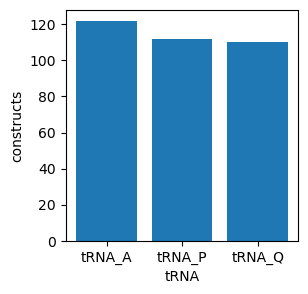

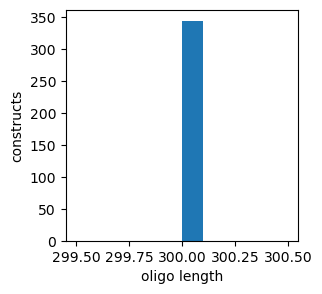

In [18]:
plt.figure(figsize=(3,3))
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

In [19]:
# oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")),index=False)
# oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")),index=False)